# Enterprise OCR with Mistral: Healthcare Document Processing

Healthcare generates 30% of the world's data, yet much of it remains locked in PDFs, scanned faxes, and unstructured documents. As regulations like the CMS prior authorization mandate push toward digital-first operations and hospital staffing shortages intensify, automated document processing has become critical infrastructure, not just for patient intake, but for back office operations like invoice management, medical billing and coding, and clinical documentation at scale.

**Key challenges driving OCR adoption:**

*   30% of global data originates in healthcare, mostly unstructured
*   Legacy systems rely on paper, fax, and non-digital formats
*   Regulatory pressure (CMS mandates, interoperability requirements)
*   Severe staffing shortages across clinical and administrative roles

**Mistral OCR v3** handles intricate healthcare documents—handwritten notes, nested lab tables, checkboxes, and multi-page forms—with accuracy comparable to commercial solutions at a fraction of the cost. This cookbook demonstrates how to get started.

## 1. Setup

First, let's install `mistralai` and download the document.

In [1]:
%%capture
!pip install mistralai

### Sample Document

This cookbook uses `patient-packet-completed.pdf` - a synthetic multi-page patient packet containing demographics, vitals, and clinical notes.

In [32]:
%%capture
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/hcls/patient-packet-completed.pdf

In [2]:
# Verify sample document exists
import os
pdf_path = "<your_path_to_pdf>/patient-packet-completed.pdf"

if os.path.exists(pdf_path):
    print(f"✅ Found: {pdf_path}")
    print(f"   Size: {os.path.getsize(pdf_path) / 1024:.1f} KB")
else:
    print(f"❌ File not found: {pdf_path}")
    print("   Please ensure patient-packet-completed.pdf is in the working directory")

✅ Found: patient-packet-completed.pdf
   Size: 4517.9 KB


In [ ]:
# List available sample files in the workspace
!ls -la *.pdf 2>/dev/null || echo "No PDF files found in current directory"

No PDF files found in current directory


### Create Client

We will need to set up our client. You can create an API key on [AI Studio](https://console.mistral.ai/api-keys/).

In [3]:
# Initialize Mistral client with API key
import os
from mistralai import Mistral
from google.colab import userdata

api_key = userdata.get('MISTRAL_API_KEY') # Replace with your way to retrieve API key

if not api_key:
    print("⚠️  WARNING: No API key found!")
else:
    client = Mistral(api_key=api_key)
    print("✅ Mistral client initialized")

✅ Mistral client initialized


---
## **2. Use Case: Patient Medical Record Packet OCR Processing**

This section showcases **Mistral OCR v3** capabilities using a 3-page patient packet. We will use each page to highlight various features:

| Page | Document Type | OCR Feature |
|------|--------------|-------------|
| 1 | Patient Admission Form | **Form elements** - checkboxes, handwriting, unified unicode representation |
| 2 | Vital Signs Flowsheet | **HTML table output** - complex tables with rowspan/colspan |
| 3 | Foot X-ray | **Image annotations** - embedded images with descriptions |

> **Note**: Sample data is synthetic/anonymized.


### Setup: Load and Process Document

First, let's encode the PDF and run OCR on the full packet. We'll then explore each page's output.

In [5]:
import base64

def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None

Process the full document and get the OCR output:

In [8]:
import json

# Path to your pdf (using local file)
pdf_path = "<your_path_to_pdf>/patient-packet-completed.pdf"

# Getting the base64 string
base64_pdf = encode_pdf(pdf_path)

# Call the OCR API
pdf_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_pdf}"
    },
    include_image_base64=True
)

# Convert response to JSON format
response_dict = json.loads(pdf_response.model_dump_json())

print(json.dumps(response_dict, indent=4)[0:1000]) # check the first 1000 characters

{
    "pages": [
        {
            "index": 0,
            "markdown": "Southern Cross Healthcare\n\nPatient Admission Form\n\nIMPORTANT: Please send this completed form to the hospital where you will have your procedure/surgery.\n\nPERSONAL AND ADMINISTRATION DETAILS\n\n|  Surname (family name): Thompson | Mr \u2611 Mrs \u2610 Ms \u2610 Miss \u2610 Mstr \u2610 Dr \u2610  |\n| --- | --- |\n|  First name(s): Michael | Preferred name: Mike  |\n|  Date of birth: 05, 12, 1998 | NHI: ZAA0067  |\n|  Gender: \u2611 Male \u2610 Female \u2610 I identify my gender as |   |\n|  Residential address: 124 Mapleview Dr, Springfield, IL 62629 |   |\n|  Postal address: Same as above |   |\n|  Email address: mrthompson12345@gmail.com |   |\n|  Telephone: (Home) 555-361-1492 (Business) \u2014 (Mobile) \u2014 |   |\n|  New Zealand resident: Yes \u2610 No \u2610 If No, complete the \u2018Acknowledgement Form: Non-NZ resident\u2019 (on our website).  |   |\n|  Which ethnic group do you belong to? Tick t

Southern Cross Healthcare

Patient Admission Form

IMPORTANT: Please send this completed form to the hospital where you will have your procedure/surgery.

PERSONAL AND ADMINISTRATION DETAILS

|  Surname (family name): Thompson | Mr ☑ Mrs ☐ Ms ☐ Miss ☐ Mstr ☐ Dr ☐  |
| --- | --- |
|  First name(s): Michael | Preferred name: Mike  |
|  Date of birth: 05, 12, 1998 | NHI: ZAA0067  |
|  Gender: ☑ Male ☐ Female ☐ I identify my gender as |   |
|  Residential address: 124 Mapleview Dr, Springfield, IL 62629 |   |
|  Postal address: Same as above |   |
|  Email address: mrthompson12345@gmail.com |   |
|  Telephone: (Home) 555-361-1492 (Business) — (Mobile) — |   |
|  New Zealand resident: Yes ☐ No ☐ If No, complete the ‘Acknowledgement Form: Non-NZ resident’ (on our website).  |   |
|  Which ethnic group do you belong to? Tick the box or boxes which apply to you.
☐ New Zealand European ☐ Māori ☐ Samoan ☐ Cook Island Māori ☐ Tongan ☐ Niuean ☐ Chinese ☐ Indian
☑ Other (such as Dutch, Japanese, Tokelauan) Please state: _________________________  |   |
|  General Practitioner (Name): Daniel Park | Telephone: 555-246-8239  |
|  Medical Centre: Springfield Hospital |   |
|  NEXT OF KIN/CONTACT PERSON  |   |
|  Name: Sarah Thompson | Relationship to patient: Spouse  |
|  Address: — |   |
|  Telephone: (Home) 555-246-1234 (Business) — (Mobile) — |   |

PAYMENT DETAILS

How will your procedure be paid for? Tick and complete as many as applies:

☐ Health insurance
☐ ACC
☐ DHB
☑ Paid personally
☐ Other …………………………

Details of health insurance
☐ Southern Cross Affiliated Provider contract

Name of Insurer: _________________________

Insurance Plan Name: _________________________
Membership No: _________________________

Have you obtained “prior approval” for payment? Yes ☐ No ☐
Approval No: _________________________

(Provide your prior approval letter in advance)

Additional charges

Depending on your health insurance policy or plan you may be required to pay an excess (co-payment).

You may also be required to pay for some charges such as visitor meals that are not covered by insurance, ACC or DHB.

Payment prior to surgery

You may be asked to pay a deposit 3-5 days before admission. The amount is based on the estimated cost of the procedure payable by you not otherwise covered by your insurance, ACC or DHB. The deposit will be refunded to you if the procedure is cancelled.

Methods of payment

We accept payment by EFTPOS, VISA, Mastercard, internet banking or online at our website

www.southerncrosshealthcare.co.nz (search “payment information”). Personal cheques are not accepted. We prefer not to receive payment by cash.

I will pay my account by: EFTPOS ☑ Credit Card ☐ Debit Card ☐ Internet Banking ☐

Internet banking details

Payee: Southern Cross Healthcare Ltd
Bank a/c: 12-3113-0126623-00
Particulars: Patient Name
Code: Date of Surgery e.g. 12 Sep 2020
Reference: Hospital e.g. Hamilton

Would you like to receive your invoice via email? ☑ YES ☐ NO

We will send the invoice to the email address you have provided above.

SCHL040 12/2020 Southern Cross Healthcare

Please complete the agreement section on the reverse of this page.

Kitty Wilde RN Case Manager

# Vital Signs Flow Sheet

|  Patient: Michael Thompson |   |   | Notes: Patient presents left foot pain after ladder fall. Suspected metatarsal fracture.  |   |   |   |   |
| --- | --- | --- | --- | --- | --- | --- | --- |
|  DOB: 05/12/1978  |   |   |   |   |   |   |   |
|  M/F: M  |   |   |   |   |   |   |   |
|  Physician: Dr. Emily Carter  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  Date | Weight | Temp. | BP | Pulse | Pulse OX | Pain | Initials  |
|  12/01/25 | 185 | 98.6 | 132/84 | 78 | 98 | 8 | EC  |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |

www.Patient-Advocate.com

Kitty Wilde RN 805-452-3225

# Foot X-ray

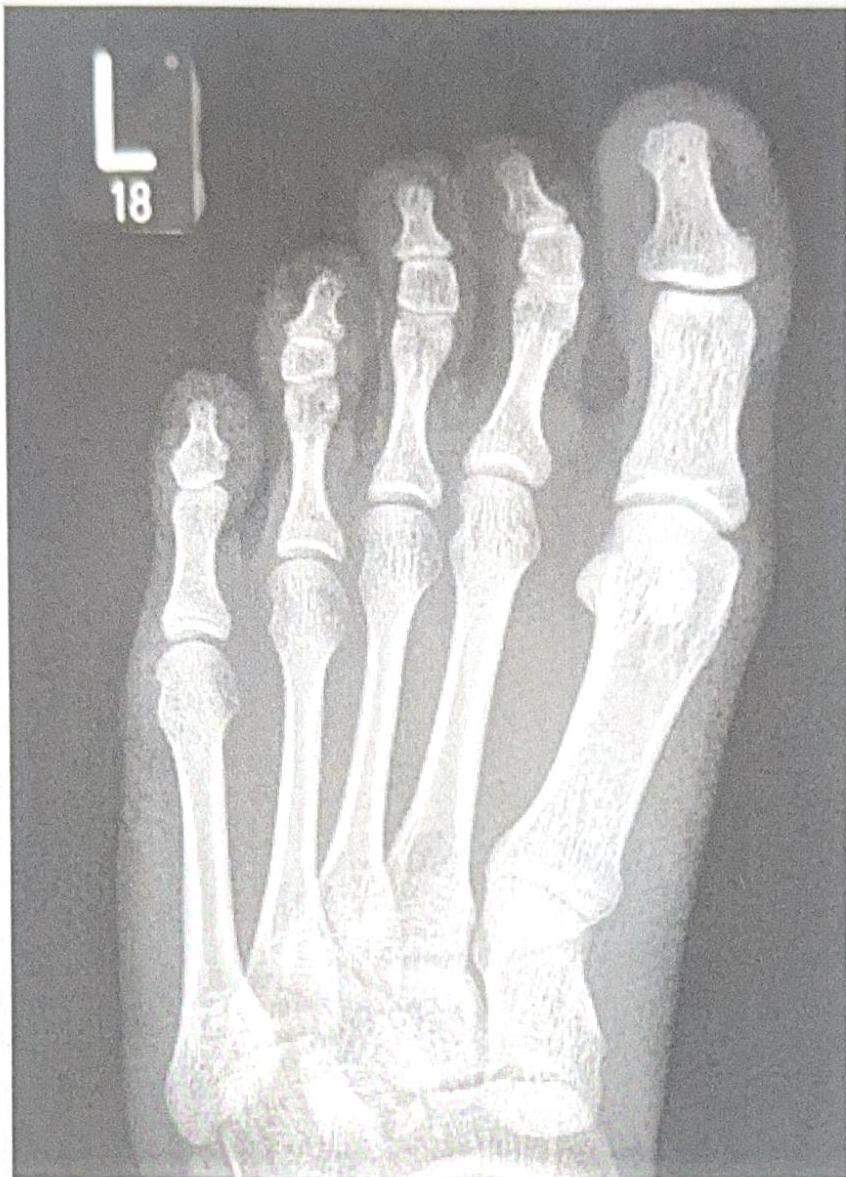

In [7]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.

    Args:
        markdown_str: Markdown text containing image placeholders
        images_dict: Dictionary mapping image IDs to base64 strings

    Returns:
        Markdown text with images replaced by base64 data
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(
            f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
        )
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
    """
    Combine OCR text and images into a single markdown document.

    Args:
        ocr_response: Response from OCR processing containing text and images

    Returns:
        Combined markdown string with embedded images
    """
    markdowns: list[str] = []
    # Extract images from page
    for page in ocr_response.pages:
        image_data = {}
        for img in page.images:
            image_data[img.id] = img.image_base64
        # Replace image placeholders with actual images
        markdowns.append(replace_images_in_markdown(page.markdown, image_data))

    return "\n\n".join(markdowns)

# Display combined markdowns and images
display(Markdown(get_combined_markdown(pdf_response)))

### 2.1 Form Elements: Checkboxes & Structured Fields (Page 1)

Page 1 contains a **Patient Admission Form** with checkboxes, handwriting, and fill-in lines. Mistral OCR v3 uses **unified Unicode checkbox representation** (☐ unchecked, ☑ checked) for consistent parsing.

In [12]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display, HTML

# Helper function to display a specific page
def display_page(ocr_response, page_index: int, title: str = None):
    """Display a single page from OCR response."""
    if page_index < len(ocr_response.pages):
        page = ocr_response.pages[page_index]
        if title:
            print(f"{'='*60}\n{title}\n{'='*60}")
        # Replace image placeholders with base64
        markdown = page.markdown
        for img in page.images:
            markdown = markdown.replace(
                f"![{img.id}]({img.id})",
                f"![{img.id}]({img.image_base64})"
            )
        display(Markdown(markdown))

# Display Page 1 - Form Elements
print("📄 PAGE 1: Patient Admission Form")
print("Notice: Checkboxes rendered as ☐ (unchecked) and ☑ (checked)")
display_page(pdf_response, 0)

📄 PAGE 1: Patient Admission Form
Notice: Checkboxes rendered as ☐ (unchecked) and ☑ (checked)


Southern Cross Healthcare

Patient Admission Form

IMPORTANT: Please send this completed form to the hospital where you will have your procedure/surgery.

PERSONAL AND ADMINISTRATION DETAILS

|  Surname (family name): Thompson | Mr ☑ Mrs ☐ Ms ☐ Miss ☐ Mstr ☐ Dr ☐  |
| --- | --- |
|  First name(s): Michael | Preferred name: Mike  |
|  Date of birth: 05, 12, 1998 | NHI: ZAA0067  |
|  Gender: ☑ Male ☐ Female ☐ I identify my gender as |   |
|  Residential address: 124 Mapleview Dr, Springfield, IL 62629 |   |
|  Postal address: Same as above |   |
|  Email address: mrthompson12345@gmail.com |   |
|  Telephone: (Home) 555-361-1492 (Business) — (Mobile) — |   |
|  New Zealand resident: Yes ☐ No ☐ If No, complete the ‘Acknowledgement Form: Non-NZ resident’ (on our website).  |   |
|  Which ethnic group do you belong to? Tick the box or boxes which apply to you.
☐ New Zealand European ☐ Māori ☐ Samoan ☐ Cook Island Māori ☐ Tongan ☐ Niuean ☐ Chinese ☐ Indian
☑ Other (such as Dutch, Japanese, Tokelauan) Please state: _________________________  |   |
|  General Practitioner (Name): Daniel Park | Telephone: 555-246-8239  |
|  Medical Centre: Springfield Hospital |   |
|  NEXT OF KIN/CONTACT PERSON  |   |
|  Name: Sarah Thompson | Relationship to patient: Spouse  |
|  Address: — |   |
|  Telephone: (Home) 555-246-1234 (Business) — (Mobile) — |   |

PAYMENT DETAILS

How will your procedure be paid for? Tick and complete as many as applies:

☐ Health insurance
☐ ACC
☐ DHB
☑ Paid personally
☐ Other …………………………

Details of health insurance
☐ Southern Cross Affiliated Provider contract

Name of Insurer: _________________________

Insurance Plan Name: _________________________
Membership No: _________________________

Have you obtained “prior approval” for payment? Yes ☐ No ☐
Approval No: _________________________

(Provide your prior approval letter in advance)

Additional charges

Depending on your health insurance policy or plan you may be required to pay an excess (co-payment).

You may also be required to pay for some charges such as visitor meals that are not covered by insurance, ACC or DHB.

Payment prior to surgery

You may be asked to pay a deposit 3-5 days before admission. The amount is based on the estimated cost of the procedure payable by you not otherwise covered by your insurance, ACC or DHB. The deposit will be refunded to you if the procedure is cancelled.

Methods of payment

We accept payment by EFTPOS, VISA, Mastercard, internet banking or online at our website

www.southerncrosshealthcare.co.nz (search “payment information”). Personal cheques are not accepted. We prefer not to receive payment by cash.

I will pay my account by: EFTPOS ☑ Credit Card ☐ Debit Card ☐ Internet Banking ☐

Internet banking details

Payee: Southern Cross Healthcare Ltd
Bank a/c: 12-3113-0126623-00
Particulars: Patient Name
Code: Date of Surgery e.g. 12 Sep 2020
Reference: Hospital e.g. Hamilton

Would you like to receive your invoice via email? ☑ YES ☐ NO

We will send the invoice to the email address you have provided above.

SCHL040 12/2020 Southern Cross Healthcare

Please complete the agreement section on the reverse of this page.

### 2.2 HTML Table Output: Vital Signs Flowsheet (Page 2)

Page 2 contains a **Vital Signs Flowsheet** with complex table structures. Mistral OCR v3 outputs tables as **HTML** with proper `rowspan` and `colspan` attributes, preserving the original structure for accurate data extraction.

In [11]:
# Display Page 2 - Vital Signs Flowsheet with HTML table
print("📄 PAGE 2: Vital Signs Flowsheet")
print("Notice: Tables output as HTML with rowspan/colspan preserved\n")

# Get the raw markdown to show the HTML structure
page2_markdown = pdf_response.pages[1].markdown
print("Raw OCR Output (showing HTML table structure):")
print("-" * 60)
print(page2_markdown[:2000])  # Show first 2000 chars of raw output
print("\n... (truncated)")

print("\n" + "="*60)
print("Rendered Output:")
print("="*60)
display(Markdown(page2_markdown))


📄 PAGE 2: Vital Signs Flowsheet
Notice: Tables output as HTML with rowspan/colspan preserved

Raw OCR Output (showing HTML table structure):
------------------------------------------------------------
Kitty Wilde RN Case Manager

# Vital Signs Flow Sheet

|  Patient: Michael Thompson |   |   | Notes: Patient presents left foot pain after ladder fall. Suspected metatarsal fracture.  |   |   |   |   |
| --- | --- | --- | --- | --- | --- | --- | --- |
|  DOB: 05/12/1978  |   |   |   |   |   |   |   |
|  M/F: M  |   |   |   |   |   |   |   |
|  Physician: Dr. Emily Carter  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  Date | Weight | Temp. | BP | Pulse | Pulse OX | Pain | Initials  |
|  12/01/25 | 185 | 98.6 | 132/84 | 78 | 98 | 8 | EC  |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  

Kitty Wilde RN Case Manager

# Vital Signs Flow Sheet

|  Patient: Michael Thompson |   |   | Notes: Patient presents left foot pain after ladder fall. Suspected metatarsal fracture.  |   |   |   |   |
| --- | --- | --- | --- | --- | --- | --- | --- |
|  DOB: 05/12/1978  |   |   |   |   |   |   |   |
|  M/F: M  |   |   |   |   |   |   |   |
|  Physician: Dr. Emily Carter  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  Date | Weight | Temp. | BP | Pulse | Pulse OX | Pain | Initials  |
|  12/01/25 | 185 | 98.6 | 132/84 | 78 | 98 | 8 | EC  |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |
|  |   |   |   |   |   |   |   |

www.Patient-Advocate.com

Kitty Wilde RN 805-452-3225

### 2.3 Image Annotations: X-ray (Page 3)

Page 3 contains an **X-ray image**. Mistral OCR v3 can detect, extract, and annotate images within documents. The image is embedded in the markdown output with base64 encoding.

📄 PAGE 3: Foot X-ray
Notice: Images are detected and embedded with base64 encoding

Images detected on this page: 1
  - Image ID: img-0.jpeg
    Dimensions: (219, 297) to (1065, 1474)

Rendered Output (with embedded X-ray image):


# Foot X-ray

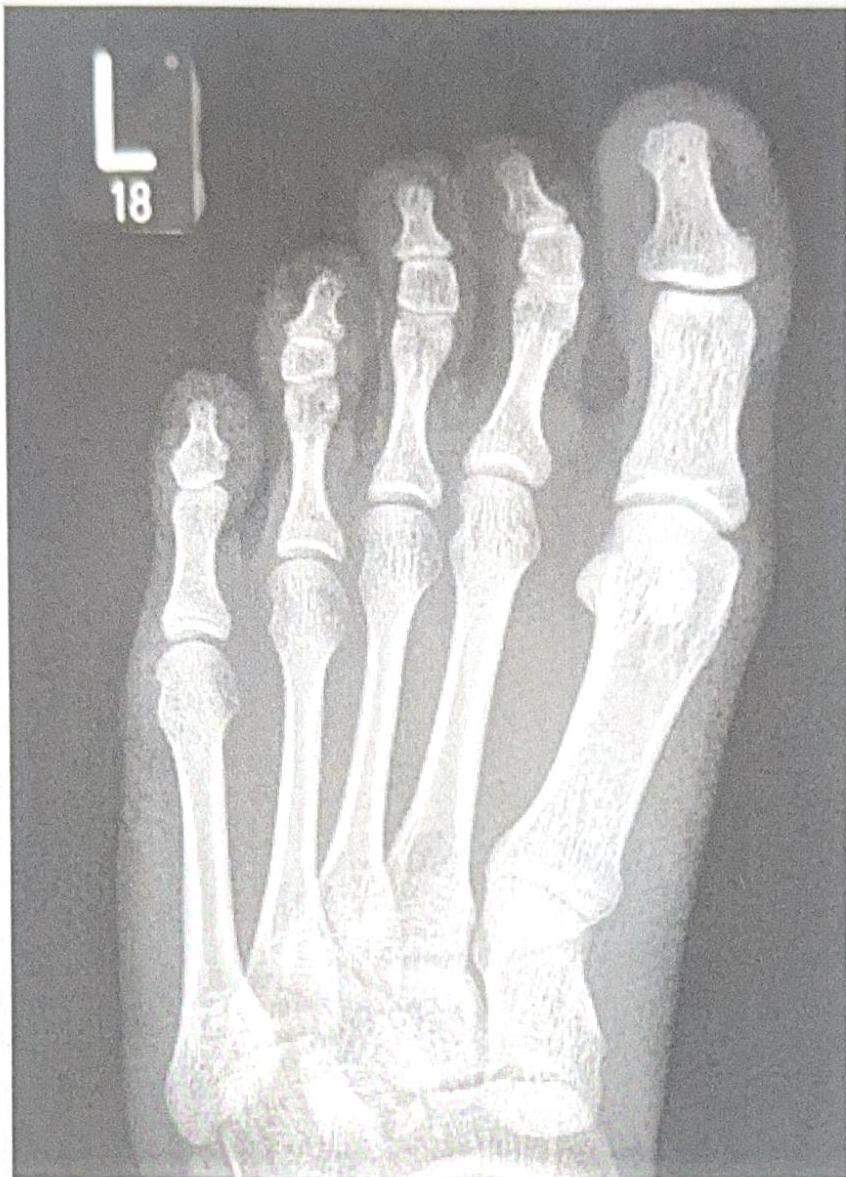

In [14]:
# Display Page 3 - X-ray Image
print("📄 PAGE 3: Foot X-ray")
print("Notice: Images are detected and embedded with base64 encoding\n")

page3 = pdf_response.pages[2]

# Show image metadata
print(f"Images detected on this page: {len(page3.images)}")
for img in page3.images:
    print(f"  - Image ID: {img.id}")
    print(f"    Dimensions: ({img.top_left_x}, {img.top_left_y}) to ({img.bottom_right_x}, {img.bottom_right_y})")

print("\n" + "="*60)
print("Rendered Output (with embedded X-ray image):")
print("="*60)

# Display page with images embedded
display_page(pdf_response, 2)

## 3. Document Intelligence Using Annotations
Moving from notebooks to production requires patterns for scale, reliability, and interoperability. This section demonstrates a **progressive pipeline** where we perform the following using DocAI Annotations:

1. **Classification** → Identify document types before extraction
2. **Batch Processing** → Handle multiple documents concurrently  
3. **FHIR Generation** → Transform extracted data into healthcare-standard formats

> **Note**: Refer to [this cookbook](https://docs.mistral.ai/cookbooks/mistral-ocr-data_extraction) for an intro to Annotations.

In [15]:
# Production Patterns Setup - imports and utilities
import base64
import json
import time
import uuid
import os
from datetime import datetime
from enum import Enum
from typing import List, Dict, Any, Optional
from dataclasses import dataclass
from collections import Counter

from pydantic import BaseModel, Field, JsonValue
from mistralai import Mistral
from mistralai.extra import response_format_from_pydantic_model
from google.colab import userdata

api_key = userdata.get('MISTRAL_API_KEY')

if not api_key:
    print("⚠️  WARNING: No API key found!")
    print("   Set MISTRAL_API_KEY environment variable, or")
    print("   Uncomment and set api_key directly above")
else:
    client = Mistral(api_key=api_key)
    print("✅ Mistral client initialized")

def encode_pdf(pdf_path: str) -> Optional[str]:
    """Encode a PDF file to base64 string."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

print("✅ Production patterns setup complete")


✅ Mistral client initialized
✅ Production patterns setup complete


### 3.1 Document Classification & Intelligent Routing

Healthcare organizations receive mixed document types daily—faxes, scanned forms, digital PDFs. Before extraction, classify incoming documents to determine:
- **Document type** (demographics, vitals, lab results, progress notes)
- **Routing destination** (billing, clinical, pharmacy)
- **Processing urgency** (stat vs routine)

This information will then inform which extraction schema to apply in the next section.


In [16]:
# Define classification schema for healthcare documents

#Possible values for incoming documents
class HealthcareDocumentType(str, Enum):
    PATIENT_DEMOGRAPHICS = "patient_demographics"
    PROGRESS_NOTES = "progress_notes"
    VITALS_FLOWSHEET = "vitals_flowsheet"
    LAB_RESULTS = "lab_results"
    MEDICATION_LIST = "medication_list"
    PRIOR_AUTHORIZATION = "prior_authorization"
    INSURANCE_CARD = "insurance_card"
    CONSENT_FORM = "consent_form"
    UNKNOWN = "unknown"

#Possible values for departments to route to
class RoutingDepartment(str, Enum):
    CLINICAL = "clinical"
    BILLING = "billing"
    PHARMACY = "pharmacy"
    RECORDS = "medical_records"
    INTAKE = "patient_intake"

#Classification schema
class DocumentClassification(BaseModel):
    document_type: HealthcareDocumentType = Field(..., description="The primary type of healthcare document")
    confidence: float = Field(..., description="Confidence score between 0.0 and 1.0")
    routing_department: RoutingDepartment = Field(..., description="Department that should handle this document")
    urgency: str = Field(..., description="Processing priority: 'stat', 'urgent', or 'routine'")
    key_identifiers_found: List[str] = Field(default=[], description="Patient identifiers detected (e.g., 'MRN', 'DOB', 'Name')")
    requires_signature: bool = Field(default=False, description="Whether document requires/contains signatures")
    summary: str = Field(..., description="One-sentence summary of document contents")


In [18]:
# Classify the patient packet document
pdf_path = "<your_path_to_pdf>/patient-packet-completed.pdf"
base64_packet = encode_pdf(pdf_path)

# First-pass classification using only page 1
classification_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_packet}"
    },
    pages=list(range(8)),  # Document Annotations has a limit of 8 pages, we recommend spliting your documents when using it; bbox annotations does not have the same limit
    document_annotation_format=response_format_from_pydantic_model(DocumentClassification),
    include_image_base64=False
)

# Parse and display classification
classification = json.loads(classification_response.document_annotation)
print("📋 Document Classification Results")
print("=" * 50)
print(f"Type:        {classification['document_type']}")
print(f"Confidence:  {classification['confidence']:.0%}")
print(f"Route to:    {classification['routing_department']}")
print(f"Urgency:     {classification['urgency']}")
print(f"Identifiers: {', '.join(classification['key_identifiers_found'])}")
print(f"Signature:   {'Yes' if classification['requires_signature'] else 'No'}")
print(f"\nSummary: {classification['summary']}")


📋 Document Classification Results
Type:        patient_demographics
Confidence:  95%
Route to:    patient_intake
Urgency:     routine
Identifiers: Name: Michael Thompson, Date of Birth: 05/12/1978, NHI: 7AA0067, Address: 124 Mapleview Dr, Springfield, IL 62629, Email: mrthompson12345@gmail.com, Phone: 555-361-1492, General Practitioner: Daniel Park, Medical Centre: Springfield Hospital, Next of Kin: Sarah Thompson, Phone: 555-246-1234
Signature:   Yes

Summary: Patient admission form for Michael Thompson, including personal details, contact information, and next of kin.


### 3.2 Classification-based Schema Extraction

Based on the classfication defined in the previous step, we'll extract different data elements from each classified document.

In [25]:
# Define type-specific extraction schemas for each document type

class PatientDemographics(BaseModel):
    """Schema for patient demographics/intake forms"""
    patient_name: str = Field(..., description="Full patient name")
    date_of_birth: str = Field(..., description="DOB in MM/DD/YYYY format")
    gender: Optional[str] = Field(None, description="Patient gender")
    address: Optional[str] = Field(None, description="Patient address")
    phone: Optional[str] = Field(None, description="Contact phone number")
    insurance_id: Optional[str] = Field(None, description="Insurance member ID")
    emergency_contact: Optional[str] = Field(None, description="Emergency contact info")

class VitalsFlowsheet(BaseModel):
    """Schema for vital signs flowsheets"""
    date_recorded: str = Field(..., description="Date vitals were recorded")
    blood_pressure: Optional[str] = Field(None, description="Blood pressure reading (systolic/diastolic)")
    heart_rate: Optional[str] = Field(None, description="Heart rate in BPM")
    temperature: Optional[str] = Field(None, description="Body temperature")
    respiratory_rate: Optional[str] = Field(None, description="Respiratory rate")
    oxygen_saturation: Optional[str] = Field(None, description="SpO2 percentage")
    weight: Optional[str] = Field(None, description="Patient weight")
    height: Optional[str] = Field(None, description="Patient height")

# Map document types to their extraction schemas
EXTRACTION_SCHEMAS: Dict[str, type] = {
    "patient_demographics": PatientDemographics,
    "vitals_flowsheet": VitalsFlowsheet,
    # Add more mappings as needed
}

print("✅ Defined extraction schemas for:", list(EXTRACTION_SCHEMAS.keys()))


✅ Defined extraction schemas for: ['patient_demographics', 'vitals_flowsheet']


### 3.3 Combine Classification & Extraction with Batch Processing

Production systems process hundreds of documents daily. This pattern extends classification & extraction to handle **multi-page packets** where each page may be a different document type (demographics, vitals, lab results, etc.).


In [26]:
@dataclass
class PageResult:
    """Result container for a single processed page"""
    page_index: int
    document_type: str
    classification: Dict[str, Any]
    extracted_data: Optional[Dict[str, Any]]
    markdown_content: str
    status: str  # "success", "error", "skipped"
    error_message: Optional[str] = None
    processing_time_ms: float = 0

def process_patient_packet(pdf_path: str, rate_limit_delay: float = 0.5) -> List[PageResult]:
    """
    Process a multi-page patient packet with per-page classification and extraction.

    Args:
        pdf_path: Path to the PDF file
        rate_limit_delay: Delay between API calls to respect rate limits

    Returns:
        List of PageResult objects with classification and extracted data
    """
    base64_pdf = encode_pdf(pdf_path)
    results = []

    # First, get the full document to know page count
    full_response = client.ocr.process(
        model="mistral-ocr-latest",
        document={
            "type": "document_url",
            "document_url": f"data:application/pdf;base64,{base64_pdf}"
        },
        include_image_base64=False
    )

    num_pages = len(full_response.pages)
    print(f"📄 Processing {num_pages} pages from {pdf_path}")
    print("-" * 50)

    for page_idx in range(num_pages):
        start_time = time.time()

        try:
            # Step 1: Classify this page
            time.sleep(rate_limit_delay)  # Rate limiting

            classify_response = client.ocr.process(
                model="mistral-ocr-latest",
                document={
                    "type": "document_url",
                    "document_url": f"data:application/pdf;base64,{base64_pdf}"
                },
                pages=[page_idx],
                document_annotation_format=response_format_from_pydantic_model(DocumentClassification),
                include_image_base64=False
            )

            page_classification = json.loads(classify_response.document_annotation)
            doc_type = page_classification["document_type"]

            # Step 2: Extract with type-specific schema if available
            extracted_data = None
            if doc_type in EXTRACTION_SCHEMAS:
                time.sleep(rate_limit_delay)

                extract_response = client.ocr.process(
                    model="mistral-ocr-latest",
                    document={
                        "type": "document_url",
                        "document_url": f"data:application/pdf;base64,{base64_pdf}"
                    },
                    pages=[page_idx],
                    document_annotation_format=response_format_from_pydantic_model(EXTRACTION_SCHEMAS[doc_type]),
                    include_image_base64=False
                )
                extracted_data = json.loads(extract_response.document_annotation)

            processing_time = (time.time() - start_time) * 1000

            result = PageResult(
                page_index=page_idx,
                document_type=doc_type,
                classification=page_classification,
                extracted_data=extracted_data,
                markdown_content=full_response.pages[page_idx].markdown,
                status="success",
                processing_time_ms=processing_time
            )

            print(f"  ✅ Page {page_idx + 1}: {doc_type} ({processing_time:.0f}ms)")

        except Exception as e:
            result = PageResult(
                page_index=page_idx,
                document_type="unknown",
                classification={},
                extracted_data=None,
                markdown_content="",
                status="error",
                error_message=str(e),
                processing_time_ms=(time.time() - start_time) * 1000
            )
            print(f"  ❌ Page {page_idx + 1}: Error - {str(e)[:50]}")

        results.append(result)

    return results

In [27]:
# Process the patient packet
batch_results = process_patient_packet("patient-packet-completed.pdf")

# Summary statistics
print("\n" + "=" * 50)
print("📊 BATCH PROCESSING SUMMARY")
print("=" * 50)
successful = [r for r in batch_results if r.status == "success"]
failed = [r for r in batch_results if r.status == "error"]

print(f"Total pages:     {len(batch_results)}")
print(f"Successful:      {len(successful)}")
print(f"Failed:          {len(failed)}")
print(f"Total time:      {sum(r.processing_time_ms for r in batch_results):.0f}ms")

# Group by document type
doc_types = Counter(r.document_type for r in successful)
print(f"\nDocument types found:")
for doc_type, count in doc_types.items():
    print(f"  • {doc_type}: {count} page(s)")

📄 Processing 3 pages from patient-packet-completed.pdf
--------------------------------------------------
  ✅ Page 1: patient_demographics (14163ms)
  ✅ Page 2: vitals_flowsheet (12173ms)
  ✅ Page 3: unknown (5579ms)

📊 BATCH PROCESSING SUMMARY
Total pages:     3
Successful:      3
Failed:          0
Total time:      31915ms

Document types found:
  • patient_demographics: 1 page(s)
  • vitals_flowsheet: 1 page(s)
  • unknown: 1 page(s)


In [28]:
# Display extracted data for each page
print("📋 EXTRACTED DATA BY PAGE")
print("=" * 50)

for result in batch_results:
    if result.status == "success":
        print(f"\n🔹 Page {result.page_index + 1}: {result.document_type}")
        print(f"   Confidence: {result.classification.get('confidence', 'N/A'):.0%}")
        print(f"   Route to: {result.classification.get('routing_department', 'N/A')}")

        if result.extracted_data:
            print("   Extracted fields:")
            for key, value in result.extracted_data.items():
                if value:  # Only show non-null values
                    print(f"     • {key}: {value}")


📋 EXTRACTED DATA BY PAGE

🔹 Page 1: patient_demographics
   Confidence: 92%
   Route to: patient_intake
   Extracted fields:
     • patient_name: Michael Thompson
     • date_of_birth: 05/12/1998
     • gender: Male
     • address: 124 Mapleview Dr, Springfield, IL 62629
     • phone: 555-361-1492
     • emergency_contact: Sarah Thompson (Spouse) - 555-246-1234

🔹 Page 2: vitals_flowsheet
   Confidence: 95%
   Route to: clinical
   Extracted fields:
     • date_recorded: 12/01/25
     • blood_pressure: 132/84
     • heart_rate: 78
     • temperature: 98.6
     • oxygen_saturation: 98
     • weight: 185

🔹 Page 3: unknown
   Confidence: 92%
   Route to: clinical


### 3.3 FHIR Resource Generation

Extracted data is only valuable if it integrates with clinical systems. **FHIR (Fast Healthcare Interoperability Resources)** is the industry standard for healthcare data exchange, supported by Epic, Cerner, and all major EHRs.

This pattern transforms our batch-extracted data into FHIR R4 resources:
- **Patient** → Demographics from intake forms
- **Observation** → Vital signs measurements  

The resulting FHIR Bundle can be POSTed to any FHIR-compliant system.


In [29]:
# FHIR R4 Resource Generation from extracted OCR data

def generate_fhir_patient(demographics: Dict[str, Any]) -> Dict[str, Any]:
    """Convert extracted demographics to FHIR R4 Patient resource"""

    # Parse name (assumes "Last, First" or "First Last" format)
    name_parts = demographics.get("patient_name", "Unknown").replace(",", " ").split()

    patient = {
        "resourceType": "Patient",
        "id": str(uuid.uuid4()),
        "meta": {
            "profile": ["http://hl7.org/fhir/us/core/StructureDefinition/us-core-patient"]
        },
        "identifier": [{
            "system": "urn:oid:2.16.840.1.113883.4.1",  # Example OID
            "value": demographics.get("insurance_id", "UNKNOWN")
        }],
        "name": [{
            "use": "official",
            "family": name_parts[0] if name_parts else "Unknown",
            "given": name_parts[1:] if len(name_parts) > 1 else []
        }],
        "birthDate": convert_date_to_fhir(demographics.get("date_of_birth")),
        "gender": map_gender(demographics.get("gender")),
    }

    # Add address if present
    if demographics.get("address"):
        patient["address"] = [{
            "use": "home",
            "text": demographics["address"]
        }]

    # Add phone if present
    if demographics.get("phone"):
        patient["telecom"] = [{
            "system": "phone",
            "value": demographics["phone"],
            "use": "home"
        }]

    return patient

def generate_fhir_vitals(vitals: Dict[str, Any], patient_id: str) -> List[Dict[str, Any]]:
    """Convert extracted vitals to FHIR R4 Observation resources"""
    observations = []

    # LOINC codes for common vitals
    vital_mappings = {
        "blood_pressure": {"code": "85354-9", "display": "Blood pressure panel"},
        "heart_rate": {"code": "8867-4", "display": "Heart rate", "unit": "/min"},
        "temperature": {"code": "8310-5", "display": "Body temperature", "unit": "Cel"},
        "respiratory_rate": {"code": "9279-1", "display": "Respiratory rate", "unit": "/min"},
        "oxygen_saturation": {"code": "2708-6", "display": "Oxygen saturation", "unit": "%"},
        "weight": {"code": "29463-7", "display": "Body weight", "unit": "kg"},
        "height": {"code": "8302-2", "display": "Body height", "unit": "cm"}
    }

    effective_date = convert_date_to_fhir(vitals.get("date_recorded")) or datetime.now().strftime("%Y-%m-%d")

    for vital_key, loinc in vital_mappings.items():
        value = vitals.get(vital_key)
        if value:
            observation = {
                "resourceType": "Observation",
                "id": str(uuid.uuid4()),
                "status": "final",
                "category": [{
                    "coding": [{
                        "system": "http://terminology.hl7.org/CodeSystem/observation-category",
                        "code": "vital-signs",
                        "display": "Vital Signs"
                    }]
                }],
                "code": {
                    "coding": [{
                        "system": "http://loinc.org",
                        "code": loinc["code"],
                        "display": loinc["display"]
                    }]
                },
                "subject": {"reference": f"Patient/{patient_id}"},
                "effectiveDateTime": effective_date,
                "valueString": str(value)  # Using string for flexibility; production would parse numeric
            }
            observations.append(observation)

    return observations

# Helper functions
def convert_date_to_fhir(date_str: Optional[str]) -> Optional[str]:
    """Convert various date formats to FHIR format (YYYY-MM-DD)"""
    if not date_str:
        return None
    # Handle MM/DD/YYYY format
    try:
        parts = date_str.replace("-", "/").split("/")
        if len(parts) == 3:
            if len(parts[0]) == 4:  # Already YYYY-MM-DD
                return date_str
            return f"{parts[2]}-{parts[0].zfill(2)}-{parts[1].zfill(2)}"
    except:
        pass
    return date_str

def map_gender(gender_str: Optional[str]) -> str:
    """Map various gender representations to FHIR values"""
    if not gender_str:
        return "unknown"
    g = gender_str.lower().strip()
    if g in ["m", "male"]:
        return "male"
    elif g in ["f", "female"]:
        return "female"
    return "unknown"

print("✅ FHIR resource generators ready")


✅ FHIR resource generators ready


In [30]:
def create_fhir_bundle_from_batch(batch_results: List[PageResult]) -> Dict[str, Any]:
    """
    Create a FHIR Bundle from batch-processed OCR results.

    Args:
        batch_results: Results from process_patient_packet()

    Returns:
        FHIR R4 Bundle resource ready for EHR integration
    """
    bundle = {
        "resourceType": "Bundle",
        "id": str(uuid.uuid4()),
        "type": "transaction",
        "timestamp": datetime.now().isoformat(),
        "entry": []
    }

    patient_id = None

    for result in batch_results:
        if result.status != "success" or not result.extracted_data:
            continue

        doc_type = result.document_type
        data = result.extracted_data

        # Generate Patient resource from demographics
        if doc_type == "patient_demographics":
            patient_resource = generate_fhir_patient(data)
            patient_id = patient_resource["id"]
            bundle["entry"].append({
                "fullUrl": f"urn:uuid:{patient_id}",
                "resource": patient_resource,
                "request": {
                    "method": "POST",
                    "url": "Patient"
                }
            })

        # Generate Observations from vitals
        elif doc_type == "vitals_flowsheet" and patient_id:
            observations = generate_fhir_vitals(data, patient_id)
            for obs in observations:
                bundle["entry"].append({
                    "fullUrl": f"urn:uuid:{obs['id']}",
                    "resource": obs,
                    "request": {
                        "method": "POST",
                        "url": "Observation"
                    }
                })

    return bundle

# Generate FHIR Bundle from our batch results
fhir_bundle = create_fhir_bundle_from_batch(batch_results)

print("🏥 FHIR BUNDLE GENERATED")
print("=" * 50)
print(f"Bundle ID: {fhir_bundle['id']}")
print(f"Bundle Type: {fhir_bundle['type']}")
print(f"Total Resources: {len(fhir_bundle['entry'])}")
print(f"\nResources by type:")
resource_types = Counter(e["resource"]["resourceType"] for e in fhir_bundle["entry"])
for rtype, count in resource_types.items():
    print(f"  • {rtype}: {count}")


🏥 FHIR BUNDLE GENERATED
Bundle ID: 3b7f5da7-1ad2-4305-b0a4-ae84360b17a0
Bundle Type: transaction
Total Resources: 6

Resources by type:
  • Patient: 1
  • Observation: 5


In [31]:
# Display the full FHIR Bundle (ready to POST to an EHR)
print("📄 FHIR BUNDLE JSON (Ready for EHR Integration)")
print("=" * 50)
print(json.dumps(fhir_bundle, indent=2))

📄 FHIR BUNDLE JSON (Ready for EHR Integration)
{
  "resourceType": "Bundle",
  "id": "3b7f5da7-1ad2-4305-b0a4-ae84360b17a0",
  "type": "transaction",
  "timestamp": "2025-12-16T19:19:36.731278",
  "entry": [
    {
      "fullUrl": "urn:uuid:6bb75ca1-ad87-4cef-b8bc-921b53478d73",
      "resource": {
        "resourceType": "Patient",
        "id": "6bb75ca1-ad87-4cef-b8bc-921b53478d73",
        "meta": {
          "profile": [
            "http://hl7.org/fhir/us/core/StructureDefinition/us-core-patient"
          ]
        },
        "identifier": [
          {
            "system": "urn:oid:2.16.840.1.113883.4.1",
            "value": null
          }
        ],
        "name": [
          {
            "use": "official",
            "family": "Michael",
            "given": [
              "Thompson"
            ]
          }
        ],
        "birthDate": "1998-05-12",
        "gender": "male",
        "address": [
          {
            "use": "home",
            "text": "124 Mapl

---
## 4. Summary & Next Steps

This cookbook demonstrated a **complete production pipeline** for healthcare OCR:

| Pattern | Purpose | Key Benefit |
|---------|---------|-------------|
| **Classification** | Identify document types | Route to correct extraction schema |
| **Batch Processing** | Handle multi-page packets | Scale with rate limiting & error isolation |
| **FHIR Generation** | Convert to healthcare standards | Integrate with Epic, Cerner, any FHIR EHR |

**Production enhancements to consider:**
- **Confidence thresholds** → Flag low-confidence extractions for human review
- **Async processing** → Use `asyncio` for higher throughput
- **Audit logging** → Track PHI access for HIPAA compliance
- **FHIR validation** → Validate bundles against US Core profiles before submission
- **Webhook notifications** → Alert downstream systems when processing completes
